# ARIMA for Anomaly Detection in Time Series Data

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import joblib
from itertools import product
from pathlib import Path
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

## ARIMA for conductivity

### Hierachical training method

In [20]:
# -----------------------------------------------
# 1. LOAD AND PREPARE YOUR DATASET
# -----------------------------------------------

# This folder contains all files w/ metrics
train_c_path = Path.cwd()/'Datasets'

# Path from data folder to the data file
train_c_filename = 'train_c_data.xlsx'

# import data file
train_c = pd.read_excel(train_c_path/train_c_filename)
train_c['timestamp'] = train_c.index
train_c

train_conduct = train_c.copy().loc[:, ['timestamp', 'run_id', 'conductivity', 'anomaly_label']]
train_conduct

,timestamp,run_id,conductivity,anomaly_label
0,0,JUL_22_1,56.32,0
1,1,JUL_22_1,56.32,0
2,2,JUL_22_1,56.17,0
3,3,JUL_22_1,56.17,0
4,4,JUL_22_1,56.17,0
...,...,...,...,...
2985,2985,JUL_22_7,56.17,0
2986,2986,JUL_22_7,56.03,0
2987,2987,JUL_22_7,56.17,0
2988,2988,JUL_22_7,56.17,0


In [19]:
# Let's make it function for further usage
def parse_and_standardize(df: pd.DataFrame, scaler: StandardScaler = None, parameter: str = df.columns[2]) -> StandardScaler:
    #df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['stand_value'] = df[parameter]
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(df['stand_value'].values.reshape(-1, 1))
    df['stand_value'] = scaler.transform(df['stand_value'].values.reshape(-1, 1))
    return scaler

data_scaler = parse_and_standardize(train_conduct)

In [ ]:
# Assume your dataset is already loaded and looks like this:
# df = pd.read_csv('your_data_file.csv')

# --- MAPPING YOUR COLUMNS ---
# Rename your columns to match the general model variables for clarity:
df = df.rename(columns={
    'timestamp': 'Date',        # Map your timestamp to 'Date' for time indexing
    'run_id': 'Run_ID',          # Map your run_id to 'Run_ID' for grouping
    'parameter': 'Parameter'    # Map your measurement to 'Parameter' (the target)
})

# Ensure 'Date' is the index and the data is sorted for time series modeling
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.sort_values(by=['Run_ID', 'Date'], inplace=True)

# -----------------------------------------------
# 2. CREATE MODELING COMPONENTS (AR and Fixed Effects)
# -----------------------------------------------

# Create the Autoregressive (AR) component (Lag_1)
# 'shift(1)' retrieves the value from the previous time step *within its own Run_ID*
df['Lag_1'] = df.groupby('Run_ID')['Parameter'].shift(1)

# Create the Fixed Effect (FE) Dummies
# This is the 'hierarchical' grouping feature
run_dummies = pd.get_dummies(df['Run_ID'], drop_first=True, prefix='Run_FE', dtype=int)
df_pooled = pd.concat([df, run_dummies], axis=1)

# Remove the rows where the lag value is NaN (usually just the first point of each run)
df_pooled.dropna(inplace=True)

# Define the dependent variable (y) and independent variables (X)
y = df_pooled['Parameter']

# X consists of the Lag, the Fixed Effect Dummies, and a Constant (Intercept)
fixed_effect_cols = [col for col in df_pooled.columns if 'Run_FE' in col]
X = sm.add_constant(df_pooled[['Lag_1'] + fixed_effect_cols])

# -----------------------------------------------
# 3. FIT THE HIERARCHICAL TIME SERIES MODEL
# -----------------------------------------------

# Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X, hasconst=True)
results = model.fit()

print("\n--- Hierarchical AR(1) Fixed Effects Model Summary ---")
print(results.summary())

# -----------------------------------------------
# 4. ANOMALY DETECTION
# -----------------------------------------------

# Calculate the residuals (the unexplained error for each point)
df_pooled['Residual'] = results.resid

# 3-Sigma Rule for Anomaly Threshold
residual_std = df_pooled['Residual'].std()
threshold = 3 * residual_std

# Flag anomalies: any residual outside the +/- 3 standard deviation range
df_pooled['Anomaly'] = np.where(
    (df_pooled['Residual'] > threshold) | (df_pooled['Residual'] < -threshold),
    1,  # Flag as Anomaly
    0   # Normal
)

# Output results
anomalies = df_pooled[df_pooled['Anomaly'] == 1]
print(f"\nTotal Anomalies Detected (using 3-sigma): {len(anomalies)}")
print("--- Sample Anomalies ---")
print(anomalies[['Run_ID', 'Parameter', 'Residual']])

### Pooled training method

#### Data preprocessing

In [2]:
# This folder contains all files w/ metrics
train_c_path = Path.cwd()/'Datasets'

# Path from data folder to the data file
train_c_filename = 'train_c_data.xlsx'

In [3]:
# import data file
train_c = pd.read_excel(train_c_path/train_c_filename)
train_c['timestamp'] = train_c.index
train_c

,run_id,time_total,conductivity,pH,temperature,voltage,anomaly_label,timestamp
0,JUL_22_1,2,56.32,4.02,49.70,3.639,0,0
1,JUL_22_1,4,56.32,4.02,49.70,3.705,0,1
2,JUL_22_1,6,56.17,4.02,49.71,3.702,0,2
3,JUL_22_1,8,56.17,4.02,49.68,3.673,0,3
4,JUL_22_1,10,56.17,4.02,49.69,3.668,0,4
...,...,...,...,...,...,...,...,...
2985,JUL_22_7,8364,56.17,4.16,49.82,3.356,0,2985
2986,JUL_22_7,8366,56.03,4.16,49.83,3.331,0,2986
2987,JUL_22_7,8368,56.17,4.16,49.83,3.339,0,2987
2988,JUL_22_7,8370,56.17,4.16,49.83,3.373,0,2988


In [4]:
# Split train and validation sets
#train, valid = train_test_split(data, test_size=0.2, shuffle=False)
#valid

In [5]:
train_conduct = train_c.copy().loc[:, ['timestamp', 'conductivity', 'anomaly_label']]

In [7]:
# create a dictionary of dataframes for each run_id in train_conduct
train_run_id = train_c['run_id'].unique()
train_c_dict = {run_id: train_conduct[train_c['run_id'] == run_id] for run_id in train_run_id}
for run_id, df in train_c_dict.items():
    df = df.copy().reset_index(drop=True)
    idx = df.index
    if isinstance(idx, pd.MultiIndex):
        # store tuple-of-levels for each row
        df['timestamp'] = [tuple(x) for x in idx]
    else:
        df['timestamp'] = idx
    train_c_dict[run_id] = df
print(train_c_dict)

# calculate key statistical metrics for each run_id, store in a dictionary
from statsmodels.tsa.stattools import acf
from scipy.stats import linregress
train_stats = {}
for run_id, df in train_c_dict.items():
    # --- 1. Calculate Trend Slope ---
    # Create a simple time index (0, 1, 2, ...) for linear regression
    time_index = np.arange(len(df))
    
    # Calculate the slope (m) and intercept (c) of the line y = m*x + c
    slope, intercept, r_value, p_value, std_err = linregress(time_index, df['stand_value'])

    # --- 2. Calculate Autocorrelation (Lag 1) ---
    # The acf function returns an array of correlation values starting at lag 0 (always 1)
    # We want the value at lag 1, so we select the second element [1].
    # We set fft=False for a standard calculation.
    autocorr_lag1 = acf(df['stand_value'], nlags=1, fft=False)[1]
    
    # --- 3. Store all metrics ---
    stats = {
        'mean': df['stand_value'].mean(),# The average standardized value
        'std': df['stand_value'].std(),  # The variability of standardized values
        'trend_slope': slope,            # The average rate of change
        'autocorr_lag1': autocorr_lag1   # The correlation with the previous time step
    }
    train_stats[run_id] = stats
    

# Convert the dictionary of dictionaries into a pandas DataFrame.
train_stats_df = pd.DataFrame.from_dict(train_stats, orient='index')    # By setting orient='index', the run_id becomes the index and the metrics become columns.

# Calculate the average (mean) for each statistical metric across all runs
average_metrics = train_stats_df[['mean', 'std', 'trend_slope', 'autocorr_lag1']].mean()

print("\n--- Individual Run Metrics ---")
print(train_stats_df)
print("\n--- Average Metrics Across All Training Runs ---")
print(average_metrics)

# Calculate the absolute deviation from the average metrics for each run
# The run with the smallest total deviation will be chosen as the representative for model fitting
df = train_stats_df.subtract(average_metrics, axis=1).abs()
df['score'] = df.sum(axis=1)
print(df)
representative_run_id = df['score'].idxmin()
print(f"\nRepresentative Run ID: {representative_run_id}")
# Extracct the representative run dataframe
rep_df = train_c_dict[representative_run_id]
print(rep_df)

{'JUL_22_1':      timestamp  conductivity  anomaly_label  stand_value
0            0         56.32              0     1.140709
1            1         56.32              0     1.140709
2            2         56.17              0     0.513631
3            3         56.17              0     0.513631
4            4         56.17              0     0.513631
..         ...           ...            ...          ...
592        592         56.10              0     0.220994
593        593         56.10              0     0.220994
594        594         56.03              0    -0.071642
595        595         56.11              0     0.262799
596        596         56.32              0     1.140709

[597 rows x 4 columns], 'JUL_22_2':      timestamp  conductivity  anomaly_label  stand_value
0            0         56.11              0     0.262799
1            1         56.10              0     0.220994
2            2         56.11              0     0.262799
3            3         56.39          

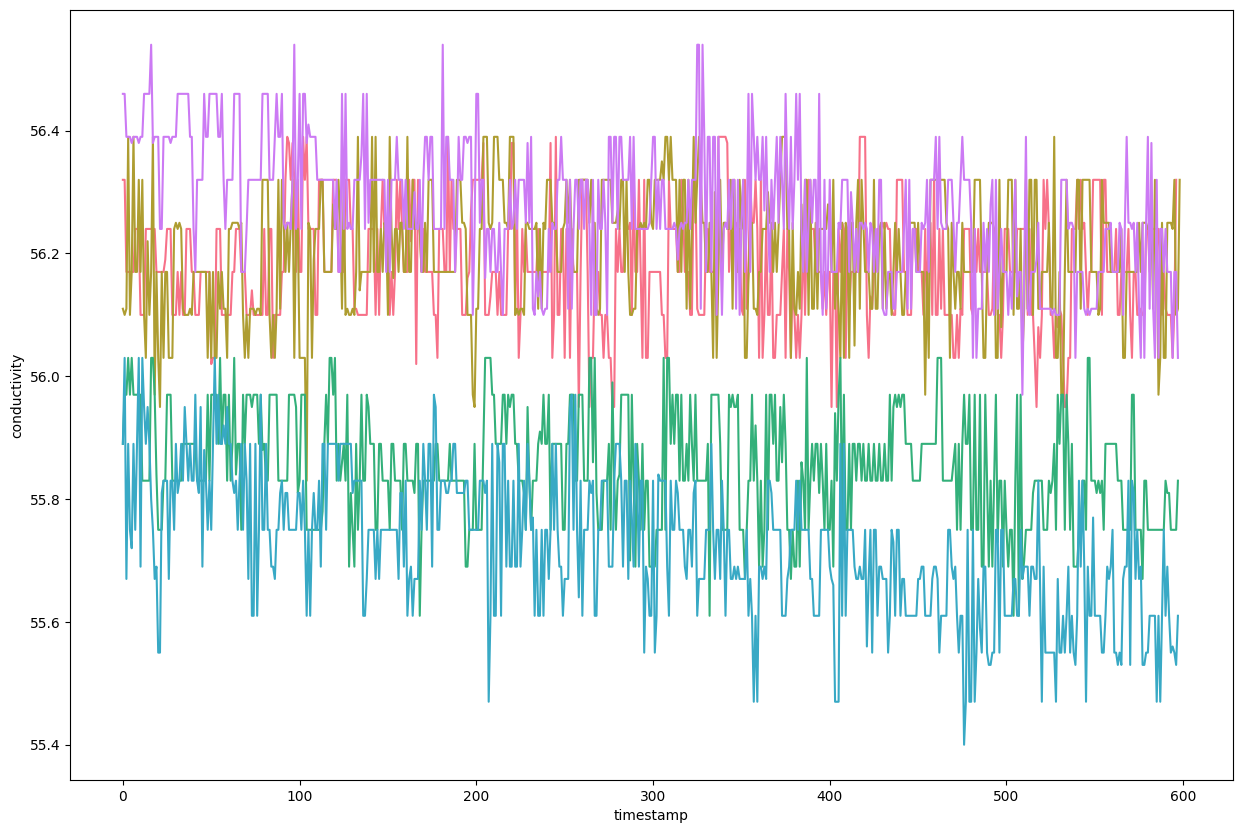

In [8]:
# Data visualization
fig, ax = plt.subplots(figsize=(15, 10))
color_palette = sns.color_palette("husl", len(train_run_id))
for run, color in zip(range(len(train_run_id)), color_palette):
    ax = sns.lineplot(data=train_c_dict[train_run_id[run]], x='timestamp', y='conductivity', color=color)
plt.show()

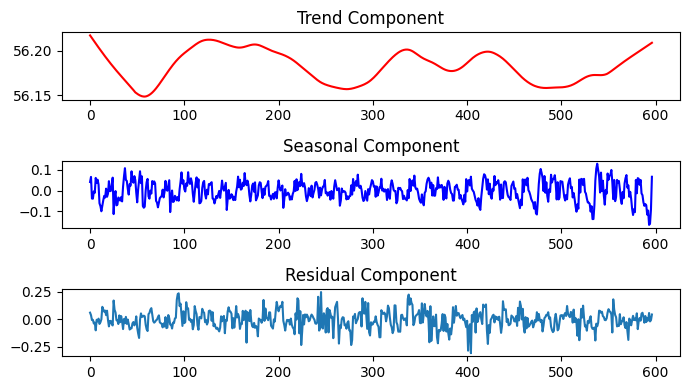

In [9]:
# Perform STL decomposition
stl = STL(rep_df['conductivity'], seasonal=21, period=60, robust=True) 
result = stl.fit()

# Plot the decomposition components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 4))

ax1.plot(rep_df.index, result.trend, label='Trend', color='red')
ax1.set_title('Trend Component')
ax2.plot(rep_df.index, result.seasonal, label='Seasonal', color='blue')
ax2.set_title('Seasonal Component')
ax3.plot(rep_df.index, result.resid, label='Residual')
ax3.set_title('Residual Component')
plt.tight_layout()
plt.show()

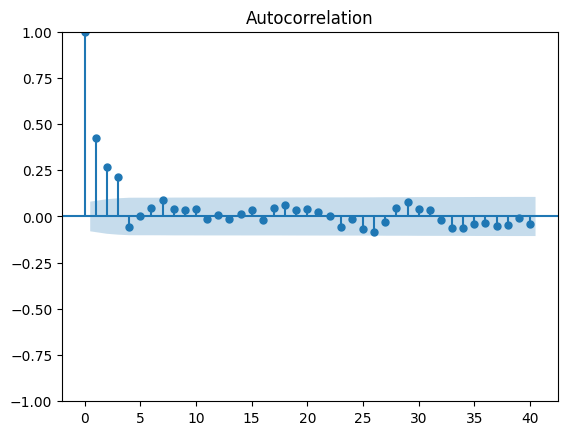

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(rep_df['conductivity'], lags=40)
plt.show()

In [11]:
# This folder contains all files w/ metrics
valid_c_path = Path.cwd()/'Datasets'

# Path from data folder to the data file
valid_c_filename = 'valid_c_data.xlsx'

In [12]:
# import data file
valid_c = pd.read_excel(valid_c_path/valid_c_filename)
valid_c['timestamp'] = valid_c.index
valid_c

,run_id,time_total,conductivity,anomaly_label,timestamp
0,JUL_22_6,5980,55.67,0,0
1,JUL_22_6,5982,55.61,0,1
2,JUL_22_6,5984,55.61,0,2
3,JUL_22_6,5986,55.61,0,3
4,JUL_22_6,5988,55.55,0,4
...,...,...,...,...,...
1192,JUL_22_8,9560,56.46,1,1192
1193,JUL_22_8,9562,56.46,1,1193
1194,JUL_22_8,9564,56.46,1,1194
1195,JUL_22_8,9566,56.46,1,1195


In [13]:
valid_conduct = valid_c.copy().loc[:, ['timestamp', 'conductivity', 'anomaly_label']]

In [14]:
parse_and_standardize(valid_conduct, data_scaler)

,copy,True
,with_mean,True
,with_std,True


In [15]:
# create a dictionary of dataframes for each run_id in valid_conduct
valid_run_id = valid_c['run_id'].unique()
valid_c_dict = {run_id: valid_conduct[valid_c['run_id'] == run_id] for run_id in valid_run_id}
for run_id, df in valid_c_dict.items():
    df = df.copy().reset_index(drop=True)
    idx = df.index
    if isinstance(idx, pd.MultiIndex):
        # store tuple-of-levels for each row
        df['timestamp'] = [tuple(x) for x in idx]
    else:
        df['timestamp'] = idx
    valid_c_dict[run_id] = df
print(valid_c_dict)

{'JUL_22_6':      timestamp  conductivity  anomaly_label  stand_value
0            0         55.67              0    -1.576629
1            1         55.61              0    -1.827460
2            2         55.61              0    -1.827460
3            3         55.61              0    -1.827460
4            4         55.55              0    -2.078292
..         ...           ...            ...          ...
594        594         55.61              0    -1.827460
595        595         55.61              0    -1.827460
596        596         55.61              0    -1.827460
597        597         55.61              0    -1.827460
598        598         55.61              0    -1.827460

[599 rows x 4 columns], 'JUL_22_8':      timestamp  conductivity  anomaly_label  stand_value
0            0         56.32              0     1.140709
1            1         56.17              0     0.513631
2            2         56.17              0     0.513631
3            3         56.17          

#### Model training

In [18]:
# --- Fixed Parameters (Determined from Stationarity/Domain Knowledge) ---
P, D, Q, s = 0, 0, 0, 2 # Eliminate all seasonality
NUM_RUNS = len(train_c_dict)

# --- Parameter Search Ranges  ---
d = range(0, 2)  # d search range (e.g., 0, 1)
ps = range(0, 4) # p search range (e.g., 0, 1, 2, 3)
qs = range(0, 4) # q search range (e.g., 0, 1, 2, 3)

# Generate combinations: only (p, q)
parameters = product(d, ps, qs)
parameters_list = list(parameters)

# --- Best Model Selection Based on Average AIC ---
best_avg_aic = float("inf")
best_param = None
best_model_results = {}
count = 0

print(f"Starting Grid Search: Testing {len(parameters_list)} parameter combinations across {NUM_RUNS} runs...")

for param in parameters_list:
    (d, p, q) = param
    
    # Define the full SARIMAX orders
    order = (p, d, q)
    seasonal_order = (P, D, Q, s)
    
    total_aic = 0
    successful_fits = 0
    count += 1
    print(f"\nTesting parameter set {count}/{len(parameters_list)}, (p={p}, d={d}, q={q})")
    
    run = 0
    
    # 1. Iterate through each independent training run
    for run_id, df in train_c_dict.items():
        run += 1
        print(f"\n-- Fitting run_id: {run_id} ({run}/{NUM_RUNS}) --")
        try:
            # 2. Fit the SARIMAX model to the single run's data
            model = sm.tsa.statespace.SARIMAX(
                df['stand_value'],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False, 
                enforce_invertibility=False
            ).fit(disp=False, method='lbfgs', maxiter=500, ftol=1e-8) # disp=False suppresses output for a cleaner loop
            
            # 3. Sum the AIC
            print(f"\nFitting converged")
            print(f"\FItted AIC: {model.aic}")
            total_aic += model.aic
            successful_fits += 1
            
        except (ValueError, np.linalg.LinAlgError) as e:
            # Handle common fitting errors (like non-invertible start)
            # We treat failed fits as having an infinite AIC
            total_aic = float("inf")
            print(f"\nFitting does not converged")
            print(f"\nFItted AIC: {total_aic}")
            break # Exit inner loop immediately if one run fails
    
    # 4. Calculate Average AIC (only if all runs were successful)
    if successful_fits == NUM_RUNS:
        avg_aic = total_aic / NUM_RUNS
        
        # 5. Check for the best model
        if avg_aic < best_avg_aic:
            best_avg_aic = avg_aic
            best_param = param
            
    # Store results (optional, for later inspection)
    best_model_results[param] = avg_aic if successful_fits == NUM_RUNS else float("inf")

# --- Final Results and Fitting the Representative Model ---

if best_param is None:
    print("\nERROR: No suitable model converged across all runs.")
else:
    d_best, p_best, q_best = best_param
    print("\n=======================================================")
    print(f"Optimal SARIMAX Structure (p, d, q): {best_param}")
    print(f"Optimal Full Order: ({p_best}, {d_best}, {q_best})({P}, {D}, {Q}, {s})")
    print(f"Minimum Average AIC: {best_avg_aic:.4f}")
    print("=======================================================")
    
    # After tuning, you select the best parameter structure (best_param).
    # You will then use this structure to fit and forecast the representative run
    # before applying it to the validation/test set, as discussed.

<>:52: SyntaxWarning: invalid escape sequence '\F'
<>:52: SyntaxWarning: invalid escape sequence '\F'
C:\Users\kittyoomm\AppData\Local\Temp\ipykernel_12164\1944059447.py:52: SyntaxWarning: invalid escape sequence '\F'
  print(f"\FItted AIC: {model.aic}")
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun

Starting Grid Search: Testing 32 parameter combinations across 5 runs...

Testing parameter set 1/32, (p=0, d=0, q=0)

-- Fitting run_id: JUL_22_1 (1/5) --

Fitting converged
\FItted AIC: 1225.4362920847655

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 1391.0456886046393

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 1559.57209743779

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 2126.7851489253494

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 1749.5752410430587

Testing parameter set 2/32, (p=0, d=0, q=1)

-- Fitting run_id: JUL_22_1 (1/5) --

Fitting converged
\FItted AIC: 868.0523583453571

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 1054.678051914955

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 1109.7518550572474

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 1549.3190718235942

-- Fitting run_id: JUL_22_7 (5/5) --

F

c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 1363.4845240860204

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 1174.7965242498067

Testing parameter set 4/32, (p=0, d=0, q=3)

-- Fitting run_id: JUL_22_1 (1/5) --

Fitting converged
\FItted AIC: 597.285295879999

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 752.7822017652245

-- Fitting run_id: JUL_22_4 (3/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 725.3317847151144

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 1071.8163432106358

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 867.8048788049784

Testing parameter set 5/32, (p=1, d=0, q=0)

-- Fitting run_id: JUL_22_1 (1/5) --

Fitting converged
\FItted AIC: 581.9432663604279

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 743.6880345308373

-- Fitting run_id: JUL_22_4 (3/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 621.5590067225409

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 758.2358035604427

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 728.3928985690742

Testing parameter set 6/32, (p=1, d=0, q=1)

-- Fitting run_id: JUL_22_1 (1/5) --

Fitting converged
\FItted AIC: 501.4354448423835

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 588.1643785628828

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 450.8838253198122

-- Fitting run_id: JUL_22_5 (4/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 526.9724494151862

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 476.5203953511891

Testing parameter set 7/32, (p=1, d=0, q=2)

-- Fitting run_id: JUL_22_1 (1/5) --

Fitting converged
\FItted AIC: 469.3991351966705

-- Fitting run_id: JUL_22_2 (2/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 563.3709136120135

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 446.9005041641105

-- Fitting run_id: JUL_22_5 (4/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 508.00758480025274

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 478.15098811616383

Testing parameter set 8/32, (p=1, d=0, q=3)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 464.06731658989867

-- Fitting run_id: JUL_22_2 (2/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 556.1950314318174

-- Fitting run_id: JUL_22_4 (3/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 424.31373474625457

-- Fitting run_id: JUL_22_5 (4/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 506.06555761470116

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 463.0335894487732

Testing parameter set 9/32, (p=2, d=0, q=0)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 528.3463240795706

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 642.2801547329636

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 495.5733871704999

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 626.6336986394285

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 569.3016597541537

Testing parameter set 10/32, (p=2, d=0, q=1)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr,


Fitting converged
\FItted AIC: 448.7678487987439

-- Fitting run_id: JUL_22_2 (2/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Fitting converged
\FItted AIC: 554.772111709291

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 434.47635943306875

-- Fitting run_id: JUL_22_5 (4/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 511.15608485849305

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 477.0097895438987

Testing parameter set 11/32, (p=2, d=0, q=2)

-- Fitting run_id: JUL_22_1 (1/5) --

Fitting converged
\FItted AIC: 472.6935615241533

-- Fitting run_id: JUL_22_2 (2/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 566.3264408970873

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 434.99305635223413

-- Fitting run_id: JUL_22_5 (4/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 492.9250787864566

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 469.2708311559452

Testing parameter set 12/32, (p=2, d=0, q=3)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 464.5636648317644

-- Fitting run_id: JUL_22_2 (2/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 558.0924631753512

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 436.8498053671343

-- Fitting run_id: JUL_22_5 (4/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 495.0952825130316

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 468.6301870283038

Testing parameter set 13/32, (p=3, d=0, q=0)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 500.82271347291464

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 580.9206537499556

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 439.63896926461746

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 490.17300772428723

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 449.85689076163646

Testing parameter set 14/32, (p=3, d=0, q=1)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 484.2560126360527

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 571.4573802673336

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 408.40987064716285

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 477.50988951849405

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 441.11909919955593

Testing parameter set 15/32, (p=3, d=0, q=2)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 486.1013480846011

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 573.4086092077736

-- Fitting run_id: JUL_22_4 (3/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 409.5073878172825

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 479.3872868655885

-- Fitting run_id: JUL_22_7 (5/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 443.04996537523664

Testing parameter set 16/32, (p=3, d=0, q=3)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr,


Fitting converged
\FItted AIC: 431.76020618673317

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 563.3677024464127

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 409.0278846557132

-- Fitting run_id: JUL_22_5 (4/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 472.6233369856774

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 438.2380962659571

Testing parameter set 17/32, (p=0, d=1, q=0)

-- Fitting run_id: JUL_22_1 (1/5) --

Fitting converged
\FItted AIC: 638.2862281744312

-- Fitting run_id: JUL_22_2 (2/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 798.731230629564

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 652.2104408357093

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 769.2635454540151

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 756.414146305548

Testing parameter set 18/32, (p=0, d=1, q=1)

-- Fitting run_id: JUL_22_1 (1/5) --

Fitting converged
\FItted AIC: 506.7048591678837

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 589.2021082461508

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 450.83599999422523

-- Fitting run_id: JUL_22_5 (4/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 514.589821968098

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 476.17056885458624

Testing parameter set 19/32, (p=0, d=1, q=2)

-- Fitting run_id: JUL_22_1 (1/5) --

Fitting converged
\FItted AIC: 467.74135021388554

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 555.1503973502763

-- Fitting run_id: JUL_22_4 (3/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 444.4117451695094

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 507.117686298824

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 477.9375814815883

Testing parameter set 20/32, (p=0, d=1, q=3)

-- Fitting run_id: JUL_22_1 (1/5) --

Fitting converged
\FItted AIC: 463.1892595499604

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 547.726540761375

-- Fitting run_id: JUL_22_4 (3/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 422.09581996720823

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 507.70574528578993

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 464.0534437453425

Testing parameter set 21/32, (p=1, d=1, q=0)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 556.3184169181786

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 663.0811344771657

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 505.616890242174

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 629.6279713356392

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 578.4503860492093

Testing parameter set 22/32, (p=1, d=1, q=1)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 445.9349507458528

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 552.1861616480828

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 432.85305069699274

-- Fitting run_id: JUL_22_5 (4/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 505.16364263936674

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 476.975675246893

Testing parameter set 23/32, (p=1, d=1, q=2)

-- Fitting run_id: JUL_22_1 (1/5) --

Fitting converged
\FItted AIC: 471.93026114127713

-- Fitting run_id: JUL_22_2 (2/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 557.6473320471928

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 433.40830908496497

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 490.80880842455207

-- Fitting run_id: JUL_22_7 (5/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 469.0382855315909

Testing parameter set 24/32, (p=1, d=1, q=3)

-- Fitting run_id: JUL_22_1 (1/5) --

Fitting converged
\FItted AIC: 463.0181710637187

-- Fitting run_id: JUL_22_2 (2/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 554.8838046301025

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 434.75622739749855

-- Fitting run_id: JUL_22_5 (4/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 492.9588190682746

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 469.19488813292753

Testing parameter set 25/32, (p=2, d=1, q=0)

-- Fitting run_id: JUL_22_1 (1/5) --

Fitting converged
\FItted AIC: 517.0898772972067

-- Fitting run_id: JUL_22_2 (2/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 590.2721324076517

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 443.5750078805947

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 489.7064385649096

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 452.9741533612933

Testing parameter set 26/32, (p=2, d=1, q=1)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr,


Fitting converged
\FItted AIC: 504.8183015020478

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 583.1907951045989

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 413.994167283552

-- Fitting run_id: JUL_22_5 (4/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 477.54200480855036

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 445.1377567324202

Testing parameter set 27/32, (p=2, d=1, q=2)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 441.1447657714804

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 576.3679808777756

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 414.42468766375276

-- Fitting run_id: JUL_22_5 (4/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 479.53050617005533

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 446.34528539582686

Testing parameter set 28/32, (p=2, d=1, q=3)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 429.5631911154397

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 569.6145838503711

-- Fitting run_id: JUL_22_4 (3/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 412.5494794688931

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 468.7082515398149

-- Fitting run_id: JUL_22_7 (5/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 439.7991768700357

Testing parameter set 29/32, (p=3, d=1, q=0)

-- Fitting run_id: JUL_22_1 (1/5) --

Fitting converged
\FItted AIC: 515.4550305271567

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 578.144767833392

-- Fitting run_id: JUL_22_4 (3/5) --

Fitting converged
\FItted AIC: 427.23185995256597

-- Fitting run_id: JUL_22_5 (4/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-package


Fitting converged
\FItted AIC: 480.3922512521808

-- Fitting run_id: JUL_22_7 (5/5) --

Fitting converged
\FItted AIC: 447.7239140321992

Testing parameter set 30/32, (p=3, d=1, q=1)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 504.8222517086206

-- Fitting run_id: JUL_22_2 (2/5) --

Fitting converged
\FItted AIC: 576.1315138721918

-- Fitting run_id: JUL_22_4 (3/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 414.1493265975622

-- Fitting run_id: JUL_22_5 (4/5) --

Fitting converged
\FItted AIC: 479.7056949111683

-- Fitting run_id: JUL_22_7 (5/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 446.8904901462123

Testing parameter set 31/32, (p=3, d=1, q=2)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 415.84011440946097

-- Fitting run_id: JUL_22_2 (2/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 504.8044124044769

-- Fitting run_id: JUL_22_4 (3/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 351.36702019517173

-- Fitting run_id: JUL_22_5 (4/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 419.58229637254874

-- Fitting run_id: JUL_22_7 (5/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 391.6880342965535

Testing parameter set 32/32, (p=3, d=1, q=3)

-- Fitting run_id: JUL_22_1 (1/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 413.1251349511281

-- Fitting run_id: JUL_22_2 (2/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 479.9492966976966

-- Fitting run_id: JUL_22_4 (3/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 343.3514906194017

-- Fitting run_id: JUL_22_5 (4/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 410.23406727792093

-- Fitting run_id: JUL_22_7 (5/5) --


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: ftol. After release 0.14, this will raise.
  warnings.warn(



Fitting converged
\FItted AIC: 383.3556696122573

Optimal SARIMAX Structure (p, d, q): (1, 3, 3)
Optimal Full Order: (3, 1, 3)(0, 0, 0, 2)
Minimum Average AIC: 406.0031


In [26]:
ARIMA_conduct = sm.tsa.statespace.SARIMAX(
    rep_df['stand_value'],
    order=(p_best, d_best, q_best),
    seasonal_order=(P, D, Q, s),
    enforce_invertibility=False,
    enforce_stationarity=False
).fit(disp=False)
print("\nFinal Model Summary (on representative run):")
print(ARIMA_conduct.summary())

all_train_results = []

for run_id, train_df in train_c_dict.items():
    train_df = train_df.copy() # Avoid SettingWithCopyWarning
    train_df['predict'] = ARIMA_conduct.predict()
    # inverse-transform train predictions
    train_df['predict_orig'] = data_scaler.inverse_transform(
        train_df['predict'].values.reshape(-1, 1)
    ).ravel()
    train_df['error'] = (train_df['conductivity'] - train_df['predict_orig']).abs()
    
    all_train_results.append(train_df)
    
# Combine all train run results into a single DataFrame for threshold tuning
train_c_df_combined = pd.concat(all_train_results)
train_c_df_combined = train_c_df_combined.reset_index(drop=True)
train_c_df_combined['timestamp'] = train_c_df_combined.index

print(f"Prediction complete. Total train data points: {len(train_c_df_combined)}")


Final Model Summary (on representative run):
                               SARIMAX Results                                
Dep. Variable:            stand_value   No. Observations:                  597
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -199.563
Date:                Tue, 21 Oct 2025   AIC                            413.125
Time:                        09:40:02   BIC                            443.810
Sample:                             0   HQIC                           425.077
                                - 597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5585      0.152     -3.684      0.000      -0.856      -0.261
ar.L2          0.1922      0.099      1.951      0.051      -0.001       0.385
ar.L3 

In [27]:
# This folder contains all files w/ metrics
model_path = Path.cwd()/'Saved_model'

# Path from data folder to the data file
model_filename = 'ARIMA_conductivity.joblib'

joblib.dump(ARIMA_conduct, model_path/model_filename)

['c:\\Users\\kittyoomm\\Desktop\\Work@MTEC\\PlateMon_TSAD-main\\Saved_model\\ARIMA_conductivity.joblib']

In [72]:
model = joblib.load(model_path/model_filename)

# Validation set forecasting
all_validation_results = []

print("Starting Out-of-Sample Forecasting for Validation Runs...")

# 1. Iterate through each independent validation run
for run_id, valid_df in valid_c_dict.items():
    
    # Forecast: Generate out-of-sample prediction for the validation run
    forecast_results = model.get_forecast(steps=len(valid_df))
    
    # Store results (Absolute Error and True Labels)
    valid_df = valid_df.copy() # Avoid SettingWithCopyWarning
    valid_df['predict'] = forecast_results.predicted_mean.reset_index(drop=True)
    # inverse-transform valid predictions
    valid_df['predict_orig'] = data_scaler.inverse_transform(
        valid_df['predict'].values.reshape(-1, 1)
    ).ravel()
    valid_df['error'] = (valid_df['conductivity'] - valid_df['predict_orig']).abs()
    
    all_validation_results.append(valid_df)
    
# Combine all validation run results into a single DataFrame for threshold tuning
valid_c_df_combined = pd.concat(all_validation_results)
valid_c_df_combined = valid_c_df_combined.reset_index(drop=True)
valid_c_df_combined['timestamp'] = valid_c_df_combined.index

print(f"Forecasting complete. Total validation data points: {len(valid_c_df_combined)}")

Starting Out-of-Sample Forecasting for Validation Runs...
Forecasting complete. Total validation data points: 239


In [69]:
forecast_results.predicted_mean

597    0.690069
598    0.672308
599    0.705063
600    0.536022
601    0.630915
         ...   
711    0.553194
712    0.553194
713    0.553194
714    0.553194
715    0.553194
Name: predicted_mean, Length: 119, dtype: float64

In [29]:
valid_c_df_combined 

,timestamp,conductivity,anomaly_label,stand_value,predict,predict_orig,error
0,0,55.61,0,-1.827460,NaN,NaN,NaN
1,1,55.53,0,-2.161902,NaN,NaN,NaN
2,2,55.55,0,-2.078292,NaN,NaN,NaN
3,3,55.53,0,-2.161902,NaN,NaN,NaN
4,4,55.55,0,-2.078292,NaN,NaN,NaN
...,...,...,...,...,...,...,...
234,234,55.33,1,-2.998006,NaN,NaN,NaN
235,235,55.47,1,-2.412733,NaN,NaN,NaN
236,236,55.53,1,-2.161902,NaN,NaN,NaN
237,237,55.81,1,-0.991356,NaN,NaN,NaN


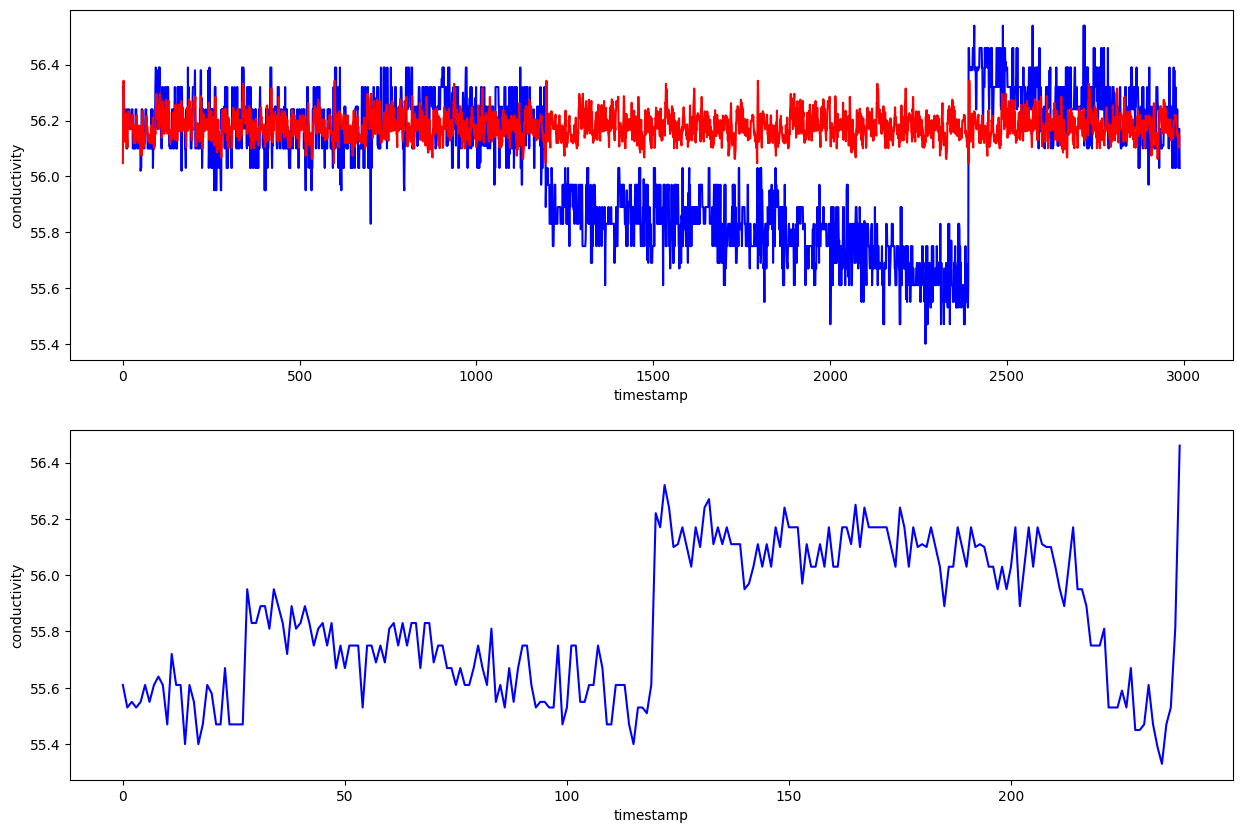

In [30]:
# Data visualization
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax1 = sns.lineplot(data=train_c_df_combined, x='timestamp', y='conductivity', color='blue', ax=ax[0])
ax1 = sns.lineplot(data=train_c_df_combined, x='timestamp', y='predict_orig', color='red', ax=ax[0])

ax2 = sns.lineplot(data=valid_c_df_combined, x='timestamp', y='conductivity', color='blue', ax=ax[1])
ax2 = sns.lineplot(data=valid_c_df_combined, x='timestamp', y='predict_orig', color='red', ax=ax[1])

plt.show()

In [32]:
def calculate_prediction_errors(input_data):
    error = (abs(input_data['conductivity']-input_data['predict_orig'])).to_numpy()
    input_data['error'] = error
    return error

In [ ]:
# Calculate the standard deviation of the absolute errors on the validation set
# We use the errors from the validation set itself to define the local noise level.
error_std = valid_conduct['error'].std()

# Define a range of std_coef values to test (e.g., from 2.0 to 5.0)
std_coef_range = np.arange(2.0, 5.1, 0.2) 

best_f1 = -1
optimal_std_coef = None
results = []

for std_coef in std_coef_range:
    df = valid_conduct.copy()
    
    # 1. Calculate the fixed threshold for this std_coef
    threshold = std_coef * error_std
    
    # 2. Classify points: 1 if error > threshold, 0 otherwise
    df['predicted_anomaly'] = (df['error'] > threshold).astype(int)
    
    # 3. Calculate metrics against the true anomaly labels
    # True labels: df['anomaly_label']
    # Predicted labels: df['predicted_anomaly']
    
    f1 = f1_score(df['anomaly_label'], df['predicted_anomaly'])
    precision = precision_score(df['anomaly_label'], df['predicted_anomaly'], zero_division=0)
    recall = recall_score(df['anomaly_label'], df['predicted_anomaly'])
    
    results.append({
        'std_coef': std_coef,
        'threshold': threshold,
        'F1_Score': f1,
        'Precision': precision,
        'Recall': recall
    })
    
    # 4. Track the optimal coefficient
    if f1 > best_f1:
        best_f1 = f1
        optimal_std_coef = std_coef

print("--- Threshold Optimization Results ---")
results_df = pd.DataFrame(results).sort_values(by='F1_Score', ascending=False)
print(results_df)

print(f"\nOptimal Standard Deviation Coefficient: {optimal_std_coef:.2f}")

--- Threshold Optimization Results ---
    std_coef  threshold  F1_Score  Precision    Recall
8        3.6   0.685202  0.285714   1.000000  0.166667
5        3.0   0.571002  0.214286   0.136364  0.500000
4        2.8   0.532935  0.206897   0.130435  0.500000
7        3.4   0.647135  0.181818   0.200000  0.166667
6        3.2   0.609068  0.181818   0.200000  0.166667
3        2.6   0.494868  0.148148   0.083333  0.666667
2        2.4   0.456801  0.142857   0.080000  0.666667
0        2.0   0.380668  0.126582   0.068493  0.833333
1        2.2   0.418735  0.103896   0.056338  0.666667
9        3.8   0.723269  0.000000   0.000000  0.000000
10       4.0   0.761336  0.000000   0.000000  0.000000
11       4.2   0.799402  0.000000   0.000000  0.000000
12       4.4   0.837469  0.000000   0.000000  0.000000
13       4.6   0.875536  0.000000   0.000000  0.000000
14       4.8   0.913603  0.000000   0.000000  0.000000
15       5.0   0.951669  0.000000   0.000000  0.000000

Optimal Standard Deviatio

In [ ]:
window = 30
std_coeff = 3

# 1. Calculate Rolling Mean of Errors
rolling_mean_series = valid_conduct['error'].rolling(window=window).mean()

# 2. Calculate Rolling Standard Deviation of Errors
rolling_std_dev_series = valid_conduct['error'].rolling(window=window).std()

# 3. Calculate the Dynamic Threshold (Mean + Coefficient * Std Dev)
thresholds = rolling_mean_series + std_coeff * rolling_std_dev_series

# 4. Assign to DataFrame and Display
valid_conduct['dynamic_threshold'] = thresholds

# You can now detect anomalies:
# valid_conduct['is_anomaly'] = valid_conduct['error'] > valid_conduct['dynamic_threshold']

# Display the DataFrame with the new threshold
valid_conduct

,timestamp,conductivity,anomaly_label,stand_value,predict,predict_orig,error,predicted_anomaly,dynamic_threshold,upper_bound
0,0,55.61,0,-1.840239,0.0,56.047279,0.437279,0,NaN,NaN
1,1,55.53,0,-2.176911,0.0,56.047279,0.517279,0,NaN,NaN
2,2,55.55,0,-2.092743,0.0,56.047279,0.497279,0,NaN,NaN
3,3,55.53,0,-2.176911,0.0,56.047279,0.517279,0,NaN,NaN
4,4,55.55,0,-2.092743,0.0,56.047279,0.497279,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
234,234,55.33,1,-3.018589,0.0,56.047279,0.717279,0,0.995122,0.800285
235,235,55.47,1,-2.429414,0.0,56.047279,0.577279,0,1.008473,0.824815
236,236,55.53,1,-2.176911,0.0,56.047279,0.517279,0,1.019086,0.842757
237,237,55.81,1,-0.998562,0.0,56.047279,0.237279,0,1.009267,0.842303


In [ ]:
def detect_anomalies(df, errors, pred_error_thresholds):
    df['error'] = errors
    df['upper_bound'] = pred_error_thresholds
    # Here we have for each value its own threshold
    indices = df.index[df['error'] >= df['upper_bound']].values.tolist()
    indices = [i for i in indices]
    return indices

valid_anomalies_idxs = detect_anomalies(
    valid_conduct, valid_conduct['error'], valid_conduct['dynamic_threshold']
)

valid_anomalies_idxs

[218, 222]

In [ ]:
valid_conduct_anomaly_predict = valid_conduct.copy().iloc[valid_anomalies_idxs, :]
valid_conduct_anomaly = valid_conduct.copy()[valid_conduct['anomaly_label'] == 1]
valid_conduct_anomaly_predict

,timestamp,conductivity,anomaly_label,stand_value,predict,predict_orig,error,predicted_anomaly,dynamic_threshold,upper_bound
218,218,55.75,0,-1.251065,0.0,56.047279,0.297279,0,0.269751,0.269751
222,222,55.53,0,-2.176911,0.0,56.047279,0.517279,0,0.459286,0.459286


In [ ]:
valid_conduct_anomaly

,timestamp,conductivity,anomaly_label,stand_value,predict,predict_orig,error,predicted_anomaly,dynamic_threshold,upper_bound
27,27,55.47,1,-2.429414,0.0,56.047279,0.577279,0,NaN,NaN
234,234,55.33,1,-3.018589,0.0,56.047279,0.717279,0,0.995122,0.995122
235,235,55.47,1,-2.429414,0.0,56.047279,0.577279,0,1.008473,1.008473
236,236,55.53,1,-2.176911,0.0,56.047279,0.517279,0,1.019086,1.019086
237,237,55.81,1,-0.998562,0.0,56.047279,0.237279,0,1.009267,1.009267
238,238,56.46,1,1.736892,0.0,56.047279,0.412721,0,1.000760,1.000760


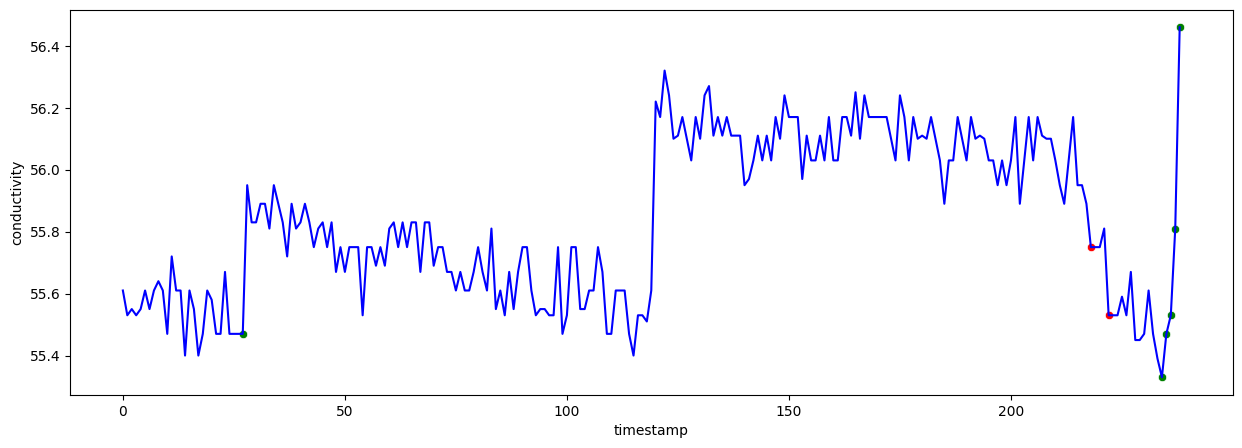

In [ ]:
# Data visualization
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(data=valid_conduct, x='timestamp', y='conductivity', color='blue')
ax = sns.scatterplot(data=valid_conduct_anomaly_predict, x='timestamp', y='conductivity', color='red', sizes=100)
ax = sns.scatterplot(data=valid_conduct_anomaly, x='timestamp', y='conductivity', color='green', sizes=10)

plt.show()

#### Confusion Matrix

In [36]:
# We are going to use this handy function for all metrics at once 
# except confusion matrix
from sklearn.metrics import precision_recall_fscore_support

def calculate_metrics(
    ground_truth: pd.DataFrame, anomalies_idxs: list
    ):
    predictions = pd.DataFrame(
        index=range(len(ground_truth)), 
        columns=['anomaly_predicted']
    )
    predictions['anomaly_predicted'] = 0
    predictions.iloc[anomalies_idxs] = 1
    
    # Calculation of the confusion matrix can be done using pandas
    confusion_matrix = pd.crosstab(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'], 
        margins=True
    )
    precision, recall, f1, _ = precision_recall_fscore_support(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'], 
        beta=2., 
        average='binary'
    )
    return confusion_matrix, precision, recall, f1

In [ ]:
train_conduct['anomaly_label'] = 0

train_conf_matrix, *train_metrics = calculate_metrics(
    train_conduct, train_anomalies_idxs
)

# Pretty printing of the metrics
print(f'Train:\n Precision: {train_metrics[0]:.3f}\n' 
      f'Recall: {train_metrics[1]:.3f}\n' 
      f'F2 score: {train_metrics[2]:.3f}')

Train:
 Precision: 0.000
Recall: 0.000
F2 score: 0.000


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
valid_conduct['anomaly_label'] = 0

valid_conf_matrix, *valid_metrics = calculate_metrics(
    valid_conduct, valid_anomalies_idxs
)

print(f'Valid:\n Precision: {valid_metrics[0]:.3f}\n' 
      f'Recall: {valid_metrics[1]:.3f}\n' 
      f'F2 score: {valid_metrics[2]:.3f}')

Valid:
 Precision: 0.000
Recall: 0.000
F2 score: 0.000


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

#### Test

In [ ]:
data_filename = 'test_c_data.xlsx'

# import data file
data = pd.read_excel(data_path/data_filename)
data['timestamp'] = data.index

test_conduct = data.copy().loc[:, ['timestamp', 'conductivity']]
test_conduct.head()

,timestamp,conductivity
0,0,55.55
1,1,55.64
2,2,55.40
3,3,55.58
4,4,55.47


In [ ]:
parse_and_standardize(test_conduct, data_scaler)
test_conduct.head()

,timestamp,conductivity,stand_value
0,0,55.55,-1.992757
1,1,55.64,-1.606439
2,2,55.40,-2.636620
3,3,55.58,-1.863984
4,4,55.47,-2.336150


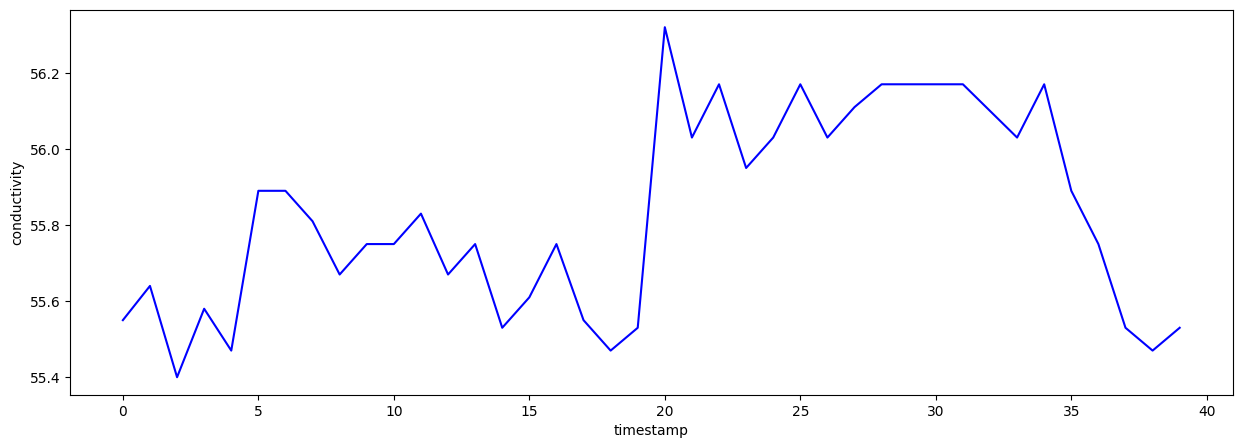

In [ ]:
# Data visualization
fig, ax = plt.subplots(figsize=(15, 5))
fig = sns.lineplot(data=test_conduct, x='timestamp', y='conductivity', color='blue')
#ax1 = sns.scatterplot(data=train_anomalies, x='timestamp', y='stand_value', color='red', ax=ax[0])

In [ ]:
test_forcast = model.get_forecast(steps=len(test_conduct))
test_conduct['predict'] = test_forcast.predicted_mean
#test_conduct['predict'].fillna(0, inplace=True)
test_conduct

,timestamp,conductivity,stand_value,predict,predict_orig
0,0,55.55,-1.992757,NaN,56.01425
1,1,55.64,-1.606439,NaN,56.01425
2,2,55.40,-2.636620,NaN,56.01425
3,3,55.58,-1.863984,NaN,56.01425
4,4,55.47,-2.336150,NaN,56.01425
5,5,55.89,-0.533333,NaN,56.01425
6,6,55.89,-0.533333,NaN,56.01425
7,7,55.81,-0.876727,NaN,56.01425
8,8,55.67,-1.477666,NaN,56.01425
9,9,55.75,-1.134272,NaN,56.01425


In [ ]:
# inverse-transform test predictions
test_conduct['predict_orig'] = data_scaler.inverse_transform(
    test_conduct['predict'].values.reshape(-1, 1)
).ravel()

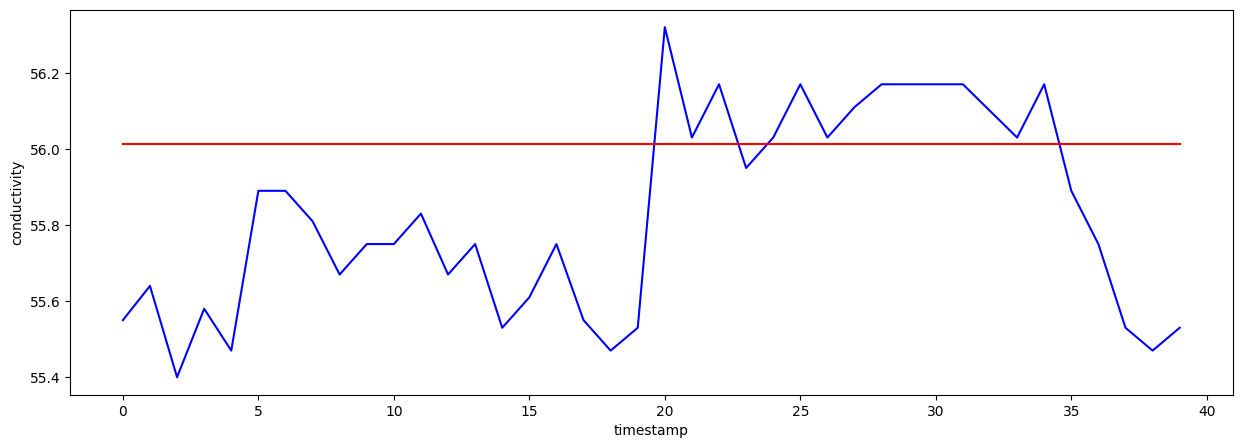

In [ ]:
# Data visualization
fig, ax = plt.subplots(figsize=(15, 5))
ax1 = sns.lineplot(data=test_conduct, x='timestamp', y='conductivity', color='blue')
ax1 = sns.lineplot(data=test_conduct, x='timestamp', y='predict_orig', color='red')

### Continuous training set

In [19]:
ARIMA_conduct = sm.tsa.statespace.SARIMAX(
    train_conduct['stand_value'],
    order=(p_best, d_best, q_best),
    seasonal_order=(P, D, Q, s),
).fit(disp=False)
print("\nFinal Model Summary (on representative run):")
print(ARIMA_conduct.summary())

train_conduct = train_conduct.copy() # Avoid SettingWithCopyWarning
train_conduct['predict'] = ARIMA_conduct.predict()
# inverse-transform train predictions
train_conduct['predict_orig'] = data_scaler.inverse_transform(
    train_conduct['predict'].values.reshape(-1, 1)
).ravel()
train_conduct['error'] = (train_conduct['conductivity'] - train_conduct['predict_orig']).abs()

print(f"Prediction complete. Total train data points: {len(train_conduct)}")


Final Model Summary (on representative run):
                               SARIMAX Results                                
Dep. Variable:            stand_value   No. Observations:                 2990
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -1191.212
Date:                Tue, 21 Oct 2025   AIC                           2396.424
Time:                        10:35:13   BIC                           2438.443
Sample:                             0   HQIC                          2411.541
                               - 2990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2761      0.049     -5.593      0.000      -0.373      -0.179
ar.L2          0.0607      0.049      1.231      0.218      -0.036       0.157
ar.L3 

In [49]:
print("Starting Out-of-Sample Forecasting for Validation Runs...")
    
# Forecast: Generate out-of-sample prediction for the validation run
forecast_results_1 = ARIMA_conduct.get_forecast(steps=len(valid_conduct))
   
# Store results (Absolute Error and True Labels)
valid_conduct['predict'] = ARIMA_conduct.predict()
valid_conduct['predicted_mean'] = pd.DataFrame(data=forecast_results_1.predicted_mean).set_index(valid_conduct.index)
# inverse-transform valid predictions
valid_conduct['predict_orig'] = data_scaler.inverse_transform(
    valid_conduct['predicted_mean'].values.reshape(-1, 1)
).ravel()
valid_conduct['error'] = (valid_conduct['conductivity'] - valid_conduct['predict_orig']).abs()

print(f"Forecasting complete. Total validation data points: {len(valid_conduct)}")

Starting Out-of-Sample Forecasting for Validation Runs...
Forecasting complete. Total validation data points: 1197


,predicted_mean
0,0.426969
1,0.357201
2,0.260707
3,0.493611
4,0.394001
...,...
1192,0.458456
1193,0.458456
1194,0.458456
1195,0.458456


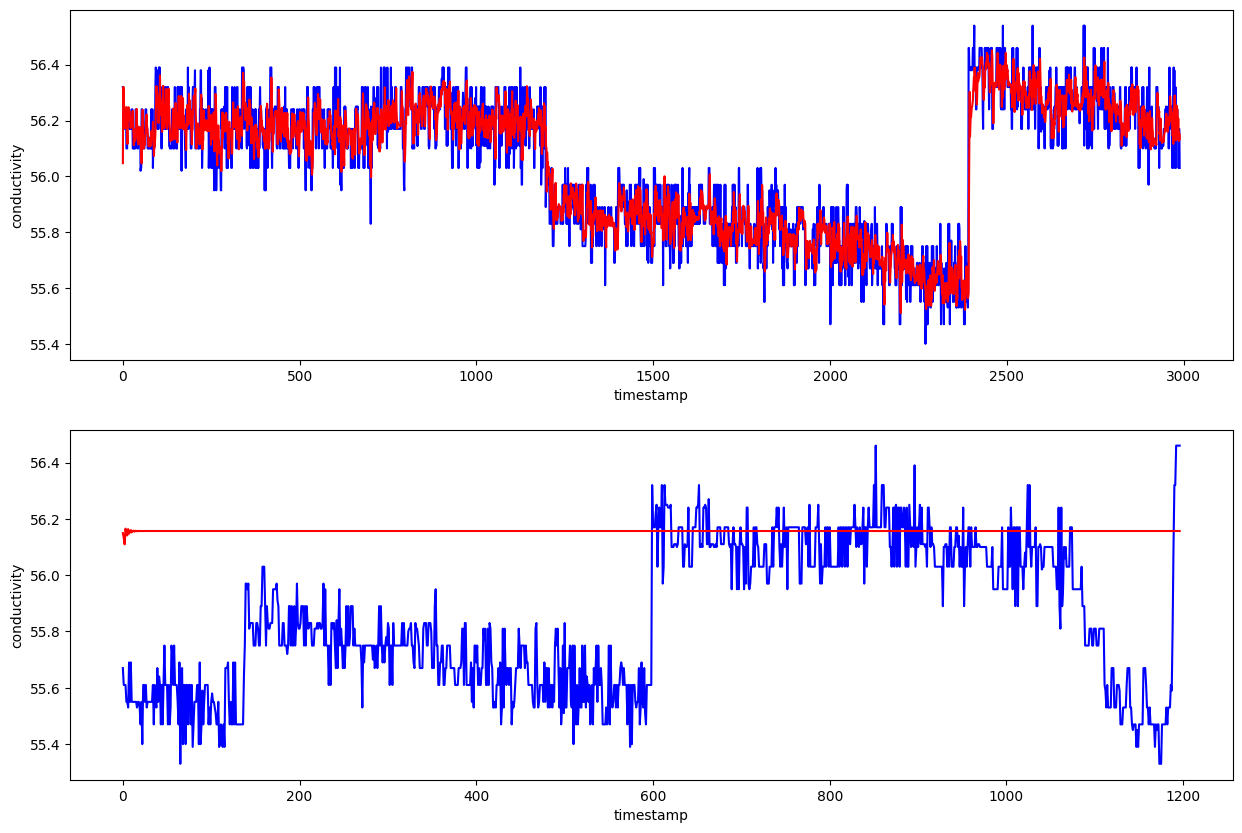

In [51]:
# Data visualization
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax1 = sns.lineplot(data=train_conduct, x='timestamp', y='conductivity', color='blue', ax=ax[0])
ax1 = sns.lineplot(data=train_conduct, x='timestamp', y='predict_orig', color='red', ax=ax[0])

ax2 = sns.lineplot(data=valid_conduct, x='timestamp', y='conductivity', color='blue', ax=ax[1])
ax2 = sns.lineplot(data=valid_conduct, x='timestamp', y='predict_orig', color='red', ax=ax[1])

plt.show()

In [52]:
# Calculate the standard deviation of the absolute errors on the validation set
# We use the errors from the validation set itself to define the local noise level.
error_std = valid_conduct['error'].std()

# Define a range of std_coef values to test (e.g., from 2.0 to 5.0)
std_coef_range = np.arange(2.0, 5.1, 0.2) 

best_f1 = -1
optimal_std_coef = None
results = []

for std_coef in std_coef_range:
    df = valid_conduct.copy()
    
    # 1. Calculate the fixed threshold for this std_coef
    threshold = std_coef * error_std
    
    # 2. Classify points: 1 if error > threshold, 0 otherwise
    df['predicted_anomaly'] = (df['error'] > threshold).astype(int)
    
    # 3. Calculate metrics against the true anomaly labels
    # True labels: df['anomaly_label']
    # Predicted labels: df['predicted_anomaly']
    
    f1 = f1_score(df['anomaly_label'], df['predicted_anomaly'])
    precision = precision_score(df['anomaly_label'], df['predicted_anomaly'], zero_division=0)
    recall = recall_score(df['anomaly_label'], df['predicted_anomaly'])
    
    results.append({
        'std_coef': std_coef,
        'threshold': threshold,
        'F1_Score': f1,
        'Precision': precision,
        'Recall': recall
    })
    
    # 4. Track the optimal coefficient
    if f1 > best_f1:
        best_f1 = f1
        optimal_std_coef = std_coef

print("--- Threshold Optimization Results ---")
results_df = pd.DataFrame(results).sort_values(by='F1_Score', ascending=False)
print(results_df)

print(f"\nOptimal Standard Deviation Coefficient: {optimal_std_coef:.2f}")

--- Threshold Optimization Results ---
    std_coef  threshold  F1_Score  Precision    Recall
7        3.4   0.789761  0.187500   0.750000  0.107143
4        2.8   0.650392  0.158730   0.102041  0.357143
6        3.2   0.743305  0.122449   0.142857  0.107143
2        2.4   0.557479  0.120968   0.068182  0.535714
3        2.6   0.603935  0.117155   0.066351  0.500000
5        3.0   0.696848  0.115385   0.125000  0.107143
1        2.2   0.511022  0.093664   0.050746  0.607143
0        2.0   0.464566  0.073913   0.039352  0.607143
8        3.6   0.836218  0.000000   0.000000  0.000000
9        3.8   0.882674  0.000000   0.000000  0.000000
10       4.0   0.929131  0.000000   0.000000  0.000000
11       4.2   0.975588  0.000000   0.000000  0.000000
12       4.4   1.022044  0.000000   0.000000  0.000000
13       4.6   1.068501  0.000000   0.000000  0.000000
14       4.8   1.114957  0.000000   0.000000  0.000000
15       5.0   1.161414  0.000000   0.000000  0.000000

Optimal Standard Deviatio

In [53]:
window = 120
std_coeff = 3

# 1. Calculate Rolling Mean of Errors
rolling_mean_series = valid_conduct['error'].rolling(window=window).mean()

# 2. Calculate Rolling Standard Deviation of Errors
rolling_std_dev_series = valid_conduct['error'].rolling(window=window).std()

# 3. Calculate the Dynamic Threshold (Mean + Coefficient * Std Dev)
thresholds = rolling_mean_series + std_coeff * rolling_std_dev_series

# 4. Assign to DataFrame and Display
valid_conduct['dynamic_threshold'] = thresholds

# You can now detect anomalies:
# valid_conduct['is_anomaly'] = valid_conduct['error'] > valid_conduct['dynamic_threshold']

# Display the DataFrame with the new threshold
valid_conduct

,timestamp,conductivity,anomaly_label,stand_value,predict,predicted_mean,predict_orig,error,dynamic_threshold,upper_bound
0,0,55.67,0,-1.576629,0.000000,0.426969,56.149270,0.479270,NaN,NaN
1,1,55.61,0,-1.827460,1.140709,0.357201,56.132581,0.522581,NaN,NaN
2,2,55.61,0,-1.827460,1.140709,0.260707,56.109499,0.499499,NaN,NaN
3,3,55.61,0,-1.827460,0.896973,0.493611,56.165211,0.555211,NaN,NaN
4,4,55.55,0,-2.078292,0.712596,0.394001,56.141384,0.591384,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1192,1192,56.46,1,1.725981,0.661224,0.458456,56.156802,0.303198,1.091330,1.158452
1193,1193,56.46,1,1.725981,0.859592,0.458456,56.156802,0.303198,1.080195,1.150342
1194,1194,56.46,1,1.725981,0.591361,0.458456,56.156802,0.303198,1.068631,1.139078
1195,1195,56.46,1,1.725981,0.518597,0.458456,56.156802,0.303198,1.065974,1.138516


In [54]:
def detect_anomalies(df, errors, pred_error_thresholds):
    df['error'] = errors
    df['upper_bound'] = pred_error_thresholds
    # Here we have for each value its own threshold
    indices = df.index[df['error'] >= df['upper_bound']].values.tolist()
    indices = [i for i in indices]
    return indices

valid_anomalies_idxs = detect_anomalies(
    valid_conduct, valid_conduct['error'], valid_conduct['dynamic_threshold']
)

valid_anomalies_idxs

[271, 852, 928, 952, 1061, 1089, 1090, 1091, 1113]

In [55]:
valid_conduct_anomaly_predict = valid_conduct.copy().iloc[valid_anomalies_idxs, :]
valid_conduct_anomaly = valid_conduct.copy()[valid_conduct['anomaly_label'] == 1]
valid_conduct_anomaly_predict

,timestamp,conductivity,anomaly_label,stand_value,predict,predicted_mean,predict_orig,error,dynamic_threshold,upper_bound
271,271,55.53,0,-2.161902,0.371312,0.458456,56.156802,0.626802,0.604020,0.604020
852,852,56.46,0,1.725981,0.770421,0.458456,56.156802,0.303198,0.251401,0.251401
928,928,55.89,0,-0.656915,0.752410,0.458456,56.156802,0.266802,0.242497,0.242497
952,952,55.89,0,-0.656915,0.207530,0.458456,56.156802,0.266802,0.252187,0.252187
1061,1061,55.81,0,-0.991356,0.990647,0.458456,56.156802,0.346802,0.326113,0.326113
1089,1089,55.75,0,-1.242188,0.809135,0.458456,56.156802,0.406802,0.375594,0.375594
1090,1090,55.75,0,-1.242188,0.792070,0.458456,56.156802,0.406802,0.389266,0.389266
1091,1091,55.75,0,-1.242188,0.751001,0.458456,56.156802,0.406802,0.402222,0.402222
1113,1113,55.53,0,-2.161902,0.818676,0.458456,56.156802,0.626802,0.596497,0.596497


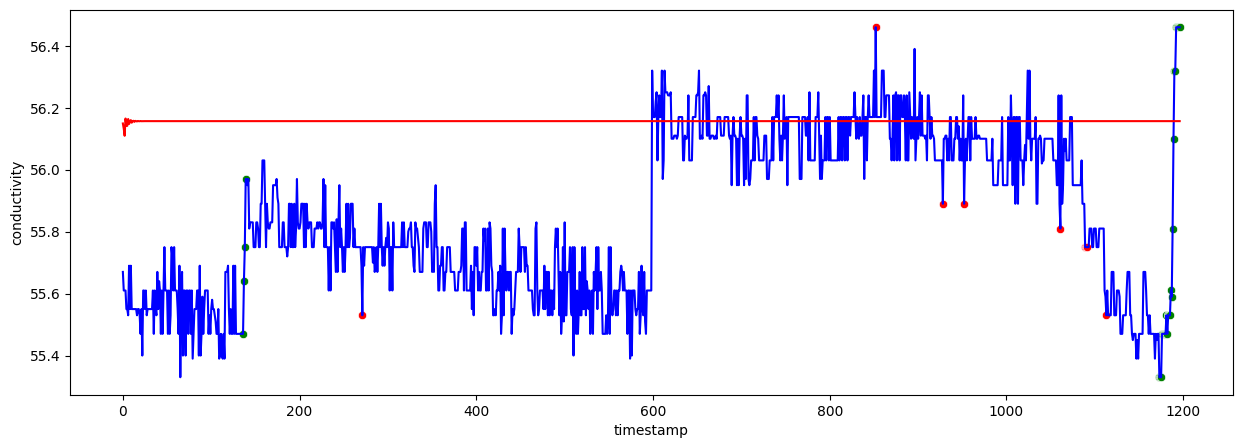

In [56]:
# Data visualization
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.lineplot(data=valid_conduct, x='timestamp', y='conductivity', color='blue')
ax = sns.lineplot(data=valid_conduct, x='timestamp', y='predict_orig', color='red', markers='-')
ax = sns.scatterplot(data=valid_conduct_anomaly_predict, x='timestamp', y='conductivity', color='red', sizes=100)
ax = sns.scatterplot(data=valid_conduct_anomaly, x='timestamp', y='conductivity', color='green', sizes=10)

plt.show()

In [57]:
valid_conf_matrix, *valid_metrics = calculate_metrics(
    valid_conduct, valid_anomalies_idxs
)

print(f'Valid:\n Precision: {valid_metrics[0]:.3f}\n' 
      f'Recall: {valid_metrics[1]:.3f}\n' 
      f'F1 score: {valid_metrics[2]:.3f}')

Valid:
 Precision: 0.000
Recall: 0.000
F1 score: 0.000
